In [1]:
import numpy as np, matplotlib.pyplot as plt
from importlib import reload
import os, time, shutil, sys
from inputs import  Inputs
from pathlib import Path
notebook_dir = Path(os.getcwd())
sys.path.append(str(notebook_dir.parent))
import data, pipelines, utils, net, infer  


if not os.path.exists('figs'):
    os.mkdir('figs')
if not os.path.exists('ckpts'):
    os.mkdir('ckpts')

### Creating setup & inspecting the data

As a public sample, we use a "virtual brain" dataset of 4 virtual slices, one from each of the healthy volunteers studied.

This dataset comprised of auxiliary T1,T2,B0,B1 maps and MT, Amide raw data as well as T1-based WM/GM masks are stored together in a xarray-based single-file serialization.


In [2]:
sample = True  # [internal] uncomment to use a single-subject full-brain dataset (e.g. "volunteer 8" used in paper)
inpt = Inputs(Path('/home/ron/pediatric-tumor-mice/Pediatric tumor model_Nov2024/20241120_134917_OrPerlman_ped_tumor_immuno_C3_2R_5_1_3'), "C3_2R_2024-11-20")
data_xa = inpt.dataset
# data_xa['B0_shift_ppm_map'] *= 0 # TODO: this makes B0 perfect
# data_xa['B1_fix_factor_map'][:] = 1.0 # TODO: this makes B1 perfect
data.SlicesFeed.norm_type = 'l2'
data_feed_mt = data.SlicesFeed.from_xarray(data_xa, mt_or_amide='mt',mt_seq_txt_fname=inpt.mt_params_path, larg_seq_txt_fname=inpt.rnoe_params_path)
data_feed_amide = data.SlicesFeed.from_xarray(data_xa, mt_or_amide='amide',mt_seq_txt_fname=inpt.mt_params_path, larg_seq_txt_fname=inpt.rnoe_params_path)

WASSR B0 mapping took 1.656 seconds


In [3]:
data_xa

<xarray.Dataset> Size: 2MB
Dimensions:            (height: 64, slice: 1, width: 64, MRF_cycles: 31)
Dimensions without coordinates: height, slice, width, MRF_cycles
Data variables:
    roi_mask_nans      (height, slice, width) float64 33kB nan nan ... nan nan
    B1_fix_factor_map  (height, slice, width) float64 33kB nan nan ... nan nan
    B0_shift_ppm_map   (height, slice, width) float64 33kB 0.0 0.0 ... 0.0 0.0
    T2ms               (height, slice, width) float64 33kB 0.0 0.0 ... 0.0 0.0
    T1ms               (height, slice, width) float64 33kB 1.388e+03 0.0 ... 0.0
    MT_data            (MRF_cycles, height, slice, width) float64 1MB 119.0 ....
    AMIDE_data         (MRF_cycles, height, slice, width) float64 1MB 89.0 .....
    white_mask         (height, slice, width) float64 33kB 0.0 0.0 ... 0.0 0.0
    gray_mask          (height, slice, width) float64 33kB 0.0 0.0 ... 0.0 0.0

/home/ron/neural-fitting/utils.py:1235: RuntimeWarning: invalid value encountered in divide
  white_red_gray_green /= np.max(white_red_gray_green)


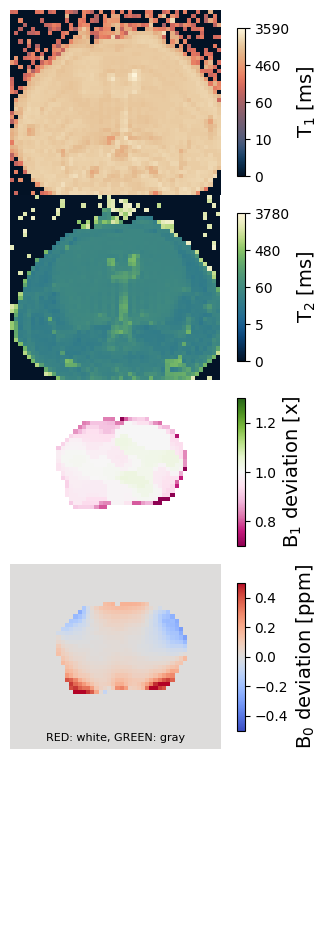

In [4]:
reload(utils)
utils.viz_t1t2b0b1_sample_slices(data_xa, data_feed_mt, sample=sample)

In [ ]:
# import utils
# reload(utils)
#
# utils.GMWM_T1T2_boxplot(data_xa)

### Solving the inverse problem using NBMF

In [5]:
do_train = True           # set to False to quickly reuse a checkpoint
sfx = 'sample' if sample else 'brain'
ckpts = os.path.abspath(f'./ckpts/{sfx}')  # edit for custom flows..

if sample: 
    pipelines.pipeline_config.mt_train_slw = 2               # quicker compile..?
    pipelines.pipeline_config.mt_patience = 100              # ensure convergence? 
    pipelines.pipeline_config.amide_patience = 20            # ensure convergence?
    # Augmentation by learnt-covariance noise: set to True for more robust training (across attempts/datasets),
    # but somewhat noisier maps - especially for the small sample dataset
    pipelines.pipeline_config.train_config.tp_noise = False

# pipelines.pipeline_config.mt_steps = 100 # TODO: remove
# pipelines.pipeline_config.amide_steps = 100 # TODO: remove

if do_train:
    shutil.rmtree(f'{ckpts}/mt', ignore_errors=True)
    shutil.rmtree(f'{ckpts}/amide', ignore_errors=True)
    predictor_mt, predictor_amide = pipelines.run_train(
        brain2train_mt=data_feed_mt, 
        brain2train_amide=data_feed_amide, 
        ckpt_folder=ckpts,
        mt_sim_mode='expm_bmmat' #,do_amide=False
        )
    # NOTE - early stopping of training can be also triggered manually by simply sending interrupt to the kernel.
    #        creation and checkpointing of the neural reconstructor will go on normally, using the weights at the moment.
else:  
    predictor_mt = net.load_ckpt(folder=f'{ckpts}/mt')[0]
    predictor_amide = net.load_ckpt(folder=f'{ckpts}/amide')[0]
    infer.infer_config = pipelines.pipeline_config.infer_config  
    # ..ideally, should be stored alongside checkpoint & used to ensure train/test consistency
    #   in pre/post-processing (i.e. network's outputs' interpretation..)

epochs = 2000
effective epochs = 500


loss_total = 3.41,signal reconstruction error (%) = 3.41 (MA: 3.35):  16%|█▌        | 323/2000 [01:16<06:36,  4.23it/s]   


Met early stopping criteria, breaking at epoch 322


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


epochs = 2000
effective epochs = 500


loss_total = 4.07,signal reconstruction error (%) = 4.07 (MA: 4.46):  10%|▉         | 190/2000 [00:51<08:14,  3.66it/s]   


Met early stopping criteria, breaking at epoch 189


#### Analyzing the resultant maps of tissue parameter estimates

100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

fss_pred mean and std: 6.679 std: 3.435


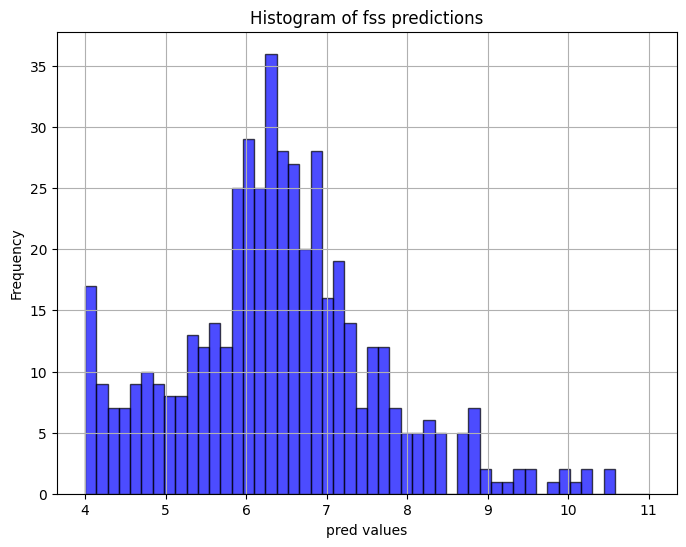

kss_pred mean and std: 50.867 std: 5.371


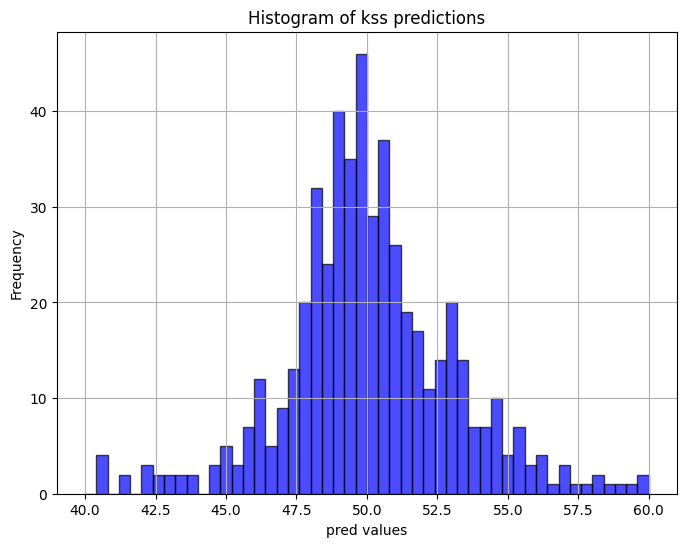

/home/ron/neural-fitting/utils.py:621: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_yticklabels(['1.00' if tick == 1 else f"{tick:.3f}".lstrip('0') for tick in cax.get_yticks()])


fs_pred mean and std: 0.506 std: 0.140


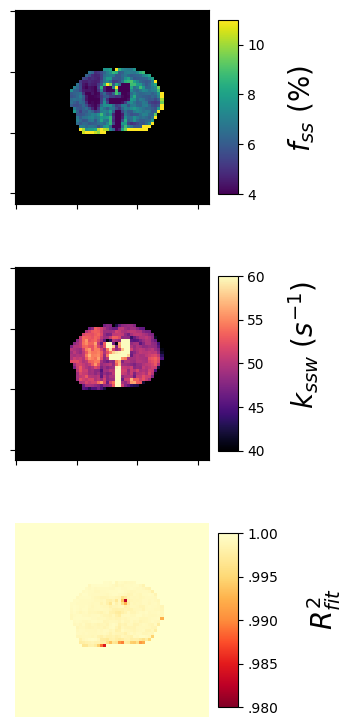

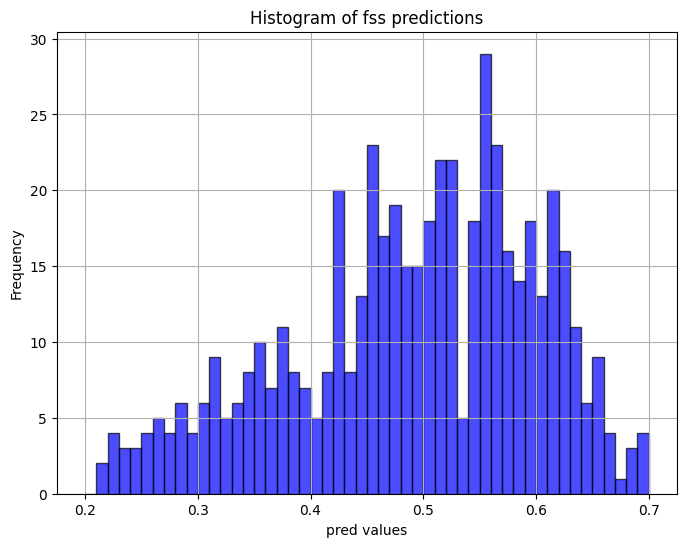

ksw_pred mean and std: 89.959 std: 18.675


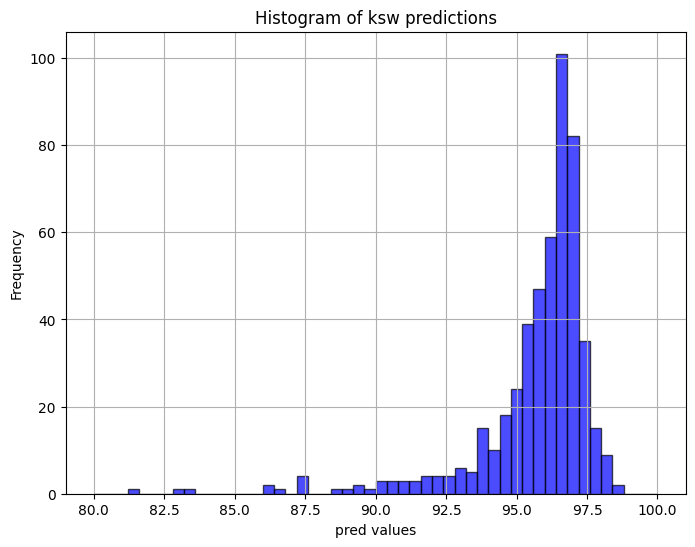

/home/ron/neural-fitting/utils.py:621: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_yticklabels(['1.00' if tick == 1 else f"{tick:.3f}".lstrip('0') for tick in cax.get_yticks()])


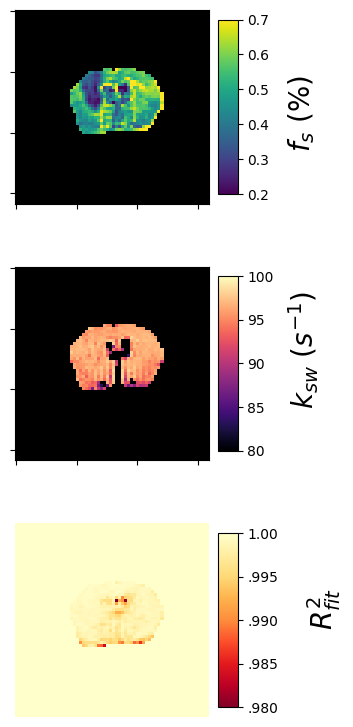

In [10]:
from importlib import reload
reload(pipelines)

transfer_res, err_mt, err_amide = pipelines.transfer_and_plot(
    brain2test_mt=data_feed_mt, brain2test_amide=data_feed_amide, 
    predictor_mt=predictor_mt, predictor_amide=predictor_amide, 
    figsfolder='./figs', figsfx='mt', slices=range(data_feed_mt.shape[1]) if sample else None,
    do_boxplots=False # TODO: change for masks
    # mask_gray=data_xa.gray_mask.values, mask_white=data_xa.white_mask.values,
    )

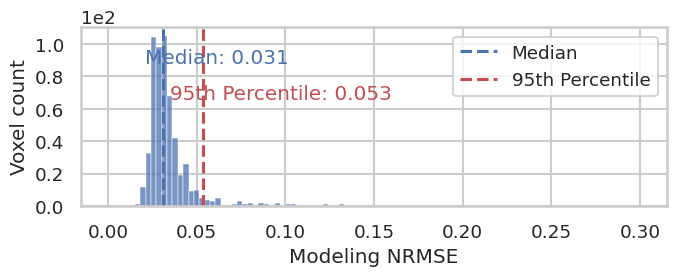

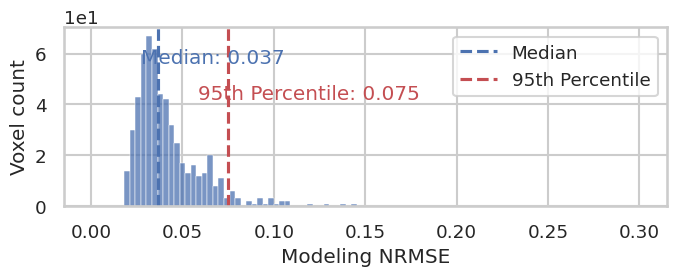

In [11]:
utils.fancy_histogram(err_mt)
utils.fancy_histogram(err_amide)

### Reference methods I: Purely voxelwise

Purely-voxelwise dictionary matching (aka dot-product, aka MRF), and per-voxel non-neural fitting (VBMF)

Demonstrated for MT, as in the Supplementary Figures 5, 6

#### Dictionary-matching

(Supplementary Figure 5)

In [9]:
from dictionary_methods import dictbased_runner; reload(dictbased_runner)

dict_as_slicefeed = dictbased_runner.get_dict() # lhs_size_x10k=200)
fss_pred_dict, kss_pred_dict, best_match, err_3d_dict = \
    dictbased_runner.match_to_dict(dict_as_slicefeed, data_feed_mt, constrain_T1T2=True) #, constrain_B0B1=True)
    

/home/alexf/neural-fitting/data.py:293: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)
  0%|                                                                                                                                                                                                                                                                    | 0/2 [00:00<?, ?it/s]/home/alexf/neural-fitting/data.py:293: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.90s/it]


0
1
2
3


/home/alexf/neural-fitting/utils.py:575: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_yticklabels(['1.00' if tick==1 else f"{tick:.3f}".lstrip('0') for tick in cax.get_yticks()])


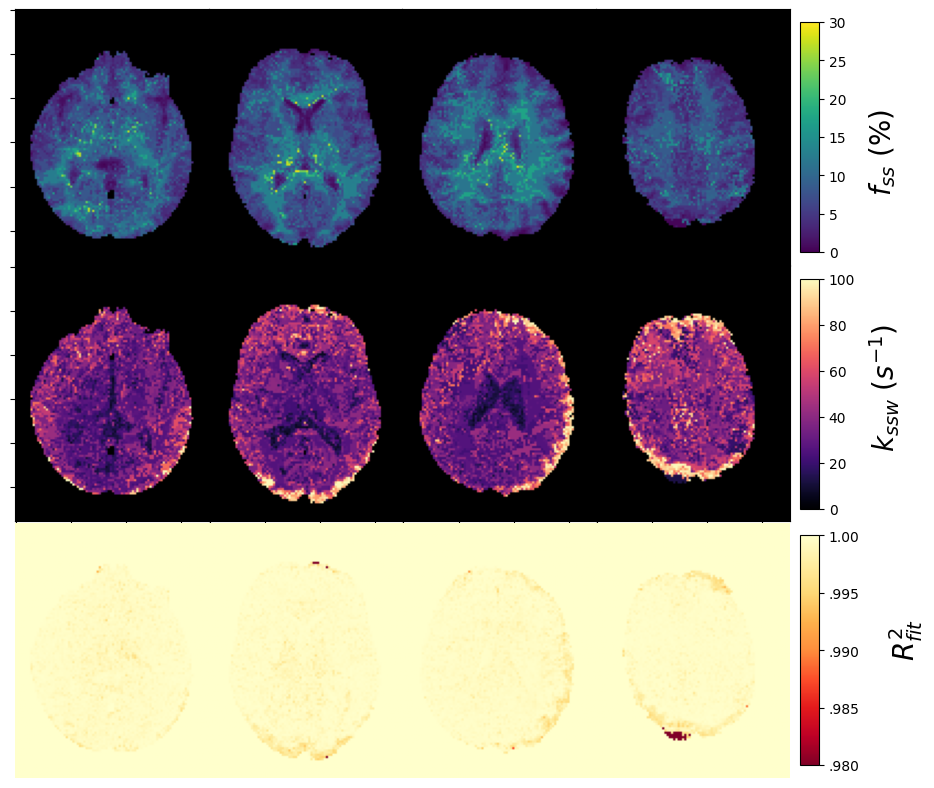

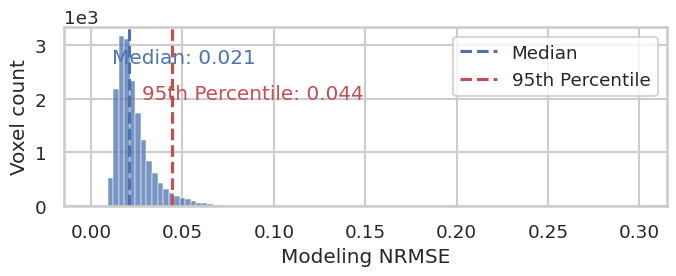

In [10]:
reload(utils)

utils.slice_row_plot(
    fss_pred_dict, kss_pred_dict, err_3d_dict, fss_lims=[0,30], kss_lims=[0,100],
    slices=range(data_feed_mt.shape[1]) if sample else None
)            
utils.fancy_histogram(err_3d_dict)

#### VBMF

(Supplementary Figure 6)

epochs = 1000
effective epochs = 1000


  0%|                                                                                                                                                                                                                                                                 | 0/2000 [00:00<?, ?it/s]/home/alexf/neural-fitting/data.py:293: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)


loss_total = 3.08,signal reconstruction error (%) = 3.08 (MA: 3.23):  28%|█████████████████████████████████████████████████▊                                                                                                                                | 560/2000 [02:06<05:26,  4.41it/s]


Met early stopping criteria, breaking at epoch 279


  0%|                                                                                                                                                                                                                                                                    | 0/2 [00:00<?, ?it/s]/home/alexf/neural-fitting/data.py:293: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.78s/it]
/home/alexf/neural-fitting/utils.py:575: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_yticklabels(['1.00' if tick==1 else f"{tick:.3f}".lstrip('0') for tick in cax.get_yticks()])


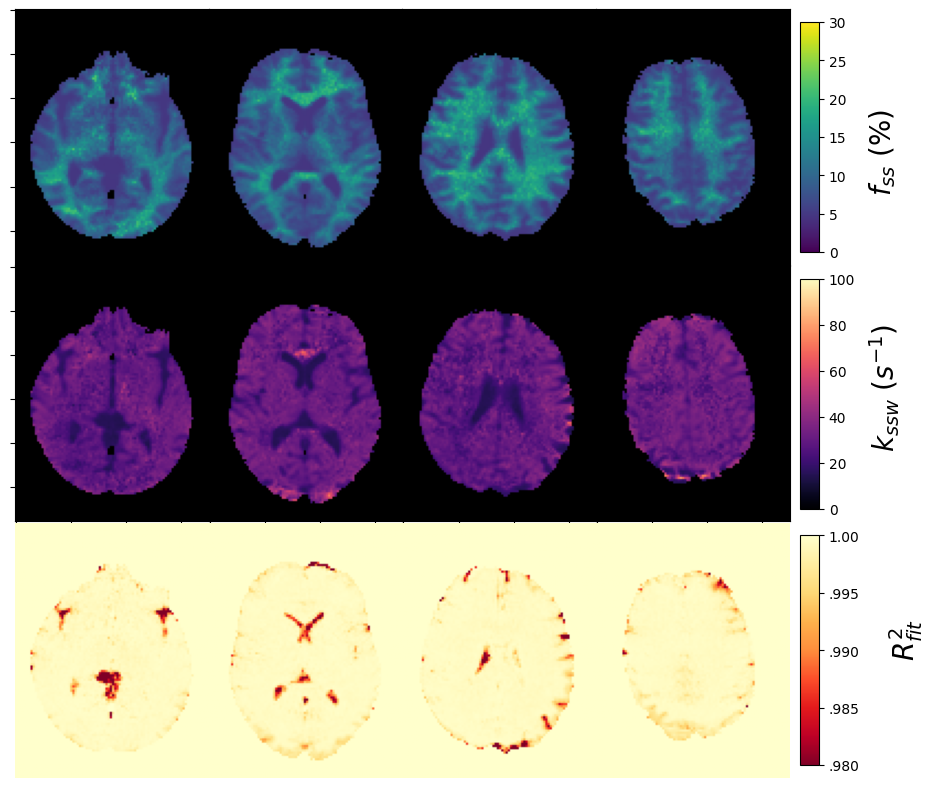

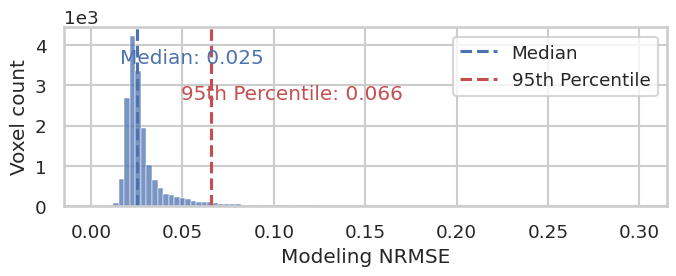

In [11]:
reload(pipelines)
data_feed_mt.slw = 2
vbmf_mt_tissue_param_est, vbmf_err_mt = pipelines.VBMF_MT_run(
    data_feed_mt,
    slices2plot=range(data_feed_mt.shape[1]) if sample else None
    )
utils.fancy_histogram(vbmf_err_mt)

### Reference methods II:  Supervised learning


In [ ]:
from dictionary_methods import dictbased_runner; 
reload(dictbased_runner)

dirname = 'supervised_figs/lhs_mt0'
if not os.path.exists(dirname):
    os.makedirs(dirname)
logger = dictbased_runner.get_logger(f'{dirname}/log.log')

# (!) params appropriate for supervised training (literature and empirically)
data.SlicesFeed.norm_type = 'l2'  # 
net.MyMLP.add_bn = False        
dict_as_slicefeed = dictbased_runner.get_dict()

for ii in range(10):        
    run_dirname = os.path.join(dirname, time.strftime('%B%d_%H%M')) # f"supervised_figs/lhs_mt0/{time.strftime('%B%d_%H%M')}/"
    if not os.path.exists(run_dirname):
        os.mkdir(run_dirname)    
    
    t0 = time.time()
    predictor_mt = dictbased_runner.train_on_dict(dict_as_slicefeed)
    logger.info(f"T(training)={time.time()-t0}sec")

    # --- Evaluate on the training set - the dictionary 
    dict_as_slicefeed.slw = 5 
    estimated_params_synth, reconstituted_signals_synth = infer.infer(dict_as_slicefeed, pool2predict='c', nn_predictor=predictor_mt)
    measured_synth_norm1st = data.SlicesFeed.normalize(dict_as_slicefeed.measured_normed_T, norm_type='first')
    reconstituted_synth_norm1st = data.SlicesFeed.normalize(reconstituted_signals_synth, norm_type='first')
    hvals, hbins = utils.signal_fit_eval_viz(measured_synth_norm1st, reconstituted_synth_norm1st)     
    plt.savefig(run_dirname + f'/err_synth.png')        
    utils.compare_fk_preds(dict_as_slicefeed, estimated_params_synth, pool='c')
    plt.savefig(run_dirname + f'/synth_est_vs_true_scatter.png')        
    err_3d_train = np.linalg.norm(reconstituted_signals_synth - dict_as_slicefeed.measured_normed_T, axis=0, ord=2)
    err_3d_train /= np.linalg.norm(dict_as_slicefeed.measured_normed_T, axis=0, ord=2)                    
    # what happens with the noise augmentation?
    dict_as_slicefeed.add_noise_to_signal = 5e-3 
    estimated_params_synth, reconstituted_signals_synth = infer.infer(dict_as_slicefeed, pool2predict='c', nn_predictor=predictor_mt)
    err_3d_train_noisy = np.linalg.norm(reconstituted_signals_synth - dict_as_slicefeed.measured_normed_T, axis=0, ord=2)
    err_3d_train_noisy /= np.linalg.norm(dict_as_slicefeed.measured_normed_T, axis=0, ord=2)      
            
    # --- Evaluate on the test set - the brain.          
    infer.infer_config.use_cfsskss_inp = False
    estimated_params_brain, reconstituted_signals_brain = infer.infer(data_feed_mt, pool2predict='c', nn_predictor=predictor_mt)
    measured_brain_norm1st = data.SlicesFeed.normalize(data_feed_mt.measured_normed_T, norm_type='first')
    reconstituted_brain_norm1st = data.SlicesFeed.normalize(reconstituted_signals_brain, norm_type='first')
    hvals, hbins = utils.signal_fit_eval_viz(measured_brain_norm1st, reconstituted_brain_norm1st)         
    plt.savefig(run_dirname + '/err_brain.png')
    err_3d_test = np.linalg.norm(reconstituted_brain_norm1st - measured_brain_norm1st, axis=0, ord=2) * data_feed_mt.roi_mask_nans 
    err_3d_test /= np.linalg.norm(data_feed_mt.measured_normed_T, axis=0, ord=2)    
    utils.slice_row_plot(
        estimated_params_brain[f'fc_T'] * data_feed_mt.roi_mask_nans * 100,
        estimated_params_brain[f'kc_T'] * data_feed_mt.roi_mask_nans,
        err_3d_test, fss_lims=[0,30], kss_lims=[0,100], slices=range(data_feed_mt.shape[1]) if sample else None
    )                            
    plt.savefig(run_dirname + '/slices_brain.png')
    
    plt.close('all')
    np.savez_compressed(run_dirname+'/err', err_mt_test=err_3d_test, err_mt_train=err_3d_train, err_3d_train_noisy=err_3d_train_noisy)

0 supervised_figs/lhs_mt0/March08_2323/err.npz
1 supervised_figs/lhs_mt0/March08_2322/err.npz
2 supervised_figs/lhs_mt0/March08_2320/err.npz
3 supervised_figs/lhs_mt0/March08_2319/err.npz
4 supervised_figs/lhs_mt0/March08_2318/err.npz
5 supervised_figs/lhs_mt0/March08_2317/err.npz
6 supervised_figs/lhs_mt0/March08_2315/err.npz
7 supervised_figs/lhs_mt0/March08_2314/err.npz
8 supervised_figs/lhs_mt0/March08_2313/err.npz
9 supervised_figs/lhs_mt0/March08_2311/err.npz


2025-03-08 23:26:27 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/home/alexf/nbmf_public/utils.py:981: UserWarning: 
The palette list has fewer values (2) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=interleaved_data, palette=sns.color_palette(["g", "r"]), showfliers=False)
2025-03-08 23:26:29 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


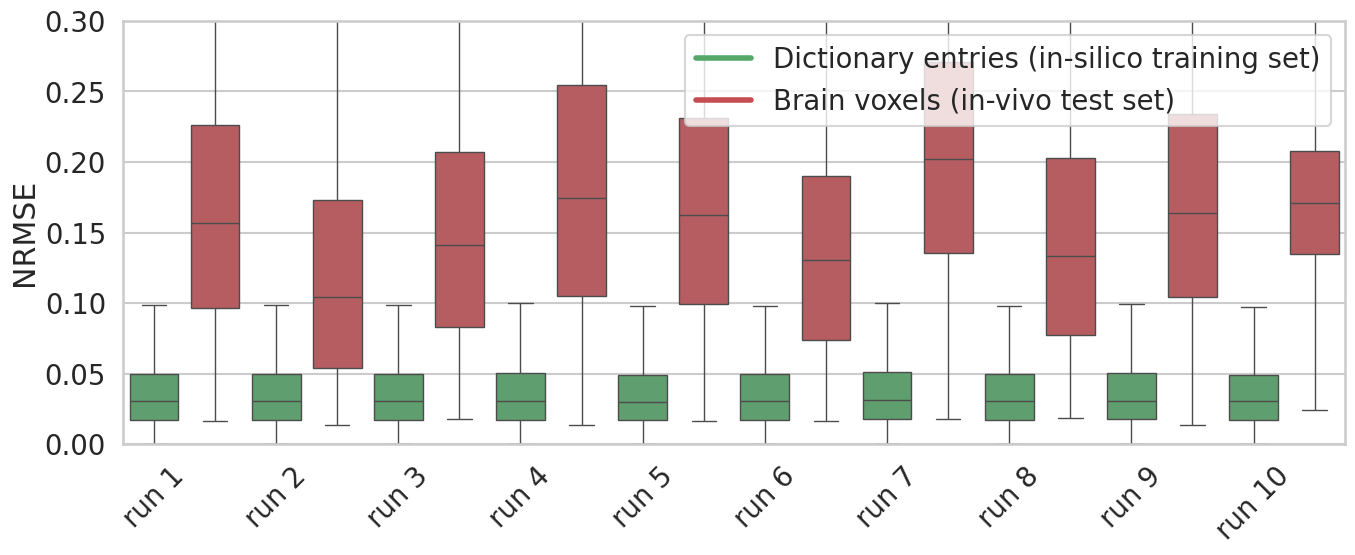

In [ ]:
reload(utils)
maindir = 'supervised_figs/lhs_mt0/'

def prep_err(err):
    return err[err!=0 & ~np.isnan(err)]
errs_self = []
errs_transfer = []    
count = 0 
err_train_key = 'err_3d_train_noisy'  # err_3d_train_noisy
err_test_key = 'err_mt_test' # 'err_3d_train_noisy' # 'err_mt_test' # 'err_mt78'
for ddir in sorted(os.listdir(maindir))[::-1]:
    full_ddir=os.path.join(maindir, ddir)
    if os.path.isdir(full_ddir) and 'err.npz' in os.listdir(full_ddir):
        fname = os.path.join(maindir, ddir, 'err.npz')
        npzf = np.load(fname)
        errs_self.append(prep_err(npzf[err_train_key].flatten()))
        errs_transfer.append(prep_err(npzf[err_test_key].flatten()))
        print(count, fname)
        count += 1
        if count>9:
            break
        
utils.robustness_boxplot_train_test(errs_self, errs_transfer)

# Uncertainty maps

In [2]:
import sys
import numpy as np, matplotlib.pyplot as plt, os
from importlib import reload
import xarray as xr, jax.numpy as jnp
from inputs import  Inputs
from pathlib import Path
notebook_dir = Path(os.getcwd())
sys.path.append(str(notebook_dir.parent))
import data, pipelines, utils, net, infer, simulation

In [ ]:
sys.path.append('..')

'/home/ron/neural-fitting/Rons'

In [2]:
data.B0_base_DEF = 7
simulation.num_flip_pulses = 1
simulation.flip_angle = 90 * jnp.pi / 180

simulation.tpulse_DEF = 2.5
simulation.tdelay_DEF = 0.1
simulation.n_pulses_DEF = 1
simulation.DO_SL = False

In [ ]:
# xarr_name = './data/ped_tumor_mice_C3_2R_2024-11-20_MT_rNOE.nc'
# xarr_name = '~/Downloads/adult_mice_data.nc'
# data_xa = xr.open_dataset(xarr_name)
#
# data_feed_mt = data.SlicesFeed.from_xarray(data_xa, mt_or_amide='mt')

inpt = Inputs(Path('/home/ron/pediatric-tumor-mice/Pediatric tumor model_Nov2024/20241120_134917_OrPerlman_ped_tumor_immuno_C3_2R_5_1_3'), "C3_2R_2024-11-20")
data_xa = inpt.dataset

data.SlicesFeed.norm_type = 'l2' #TODO: do i need this here as well?

# data_feed_mt = data.SlicesFeed.from_xarray(data_xa, mt_or_amide='mt',mt_seq_txt_fname=inpt.mt_params_path, larg_seq_txt_fname=inpt.rnoe_params_path)
# data_feed_amide = data.SlicesFeed.from_xarray(data_xa, mt_or_amide='amide',mt_seq_txt_fname=inpt.mt_params_path, larg_seq_txt_fname=inpt.rnoe_params_path)

WASSR B0 mapping took 1.684 seconds


In [4]:
data_xa

<xarray.Dataset> Size: 2MB
Dimensions:            (height: 64, slice: 1, width: 64, MRF_cycles: 31)
Dimensions without coordinates: height, slice, width, MRF_cycles
Data variables:
    roi_mask_nans      (height, slice, width) float64 33kB nan nan ... nan nan
    B1_fix_factor_map  (height, slice, width) float64 33kB nan nan ... nan nan
    B0_shift_ppm_map   (height, slice, width) float64 33kB 0.0 0.0 ... 0.0 0.0
    T2ms               (height, slice, width) float64 33kB 0.0 0.0 ... 0.0 0.0
    T1ms               (height, slice, width) float64 33kB 1.388e+03 0.0 ... 0.0
    MT_data            (MRF_cycles, height, slice, width) float64 1MB 119.0 ....
    AMIDE_data         (MRF_cycles, height, slice, width) float64 1MB 89.0 .....
    white_mask         (height, slice, width) float64 33kB 0.0 0.0 ... 0.0 0.0
    gray_mask          (height, slice, width) float64 33kB 0.0 0.0 ... 0.0 0.0

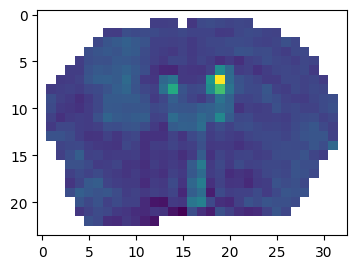

In [ ]:
data_xa_cutout = data_xa.isel(
    height=slice(18, 42),
    width=slice(17, 50)
)
plt.figure(figsize=(4,4))
plt.imshow((data_xa_cutout['T1ms'].data * data_xa_cutout['roi_mask_nans']).squeeze())

data_feed_mt = data.SlicesFeed.from_xarray(data_xa_cutout, mt_or_amide='mt',mt_seq_txt_fname=inpt.mt_params_path, larg_seq_txt_fname=inpt.rnoe_params_path)
data_feed_amide = data.SlicesFeed.from_xarray(data_xa_cutout, mt_or_amide='amide',mt_seq_txt_fname=inpt.mt_params_path, larg_seq_txt_fname=inpt.rnoe_params_path)

In [ ]:
pipelines.pipeline_config.train_config.std_up_fact = 0.2
pipelines.pipeline_config.mt_lr = 0.01
pipelines.pipeline_config.mt_steps = 500
pipelines.pipeline_config.infer_config.kc_scale_fact = 80
pipelines.pipeline_config.train_config.auto_reduce_batch = False
pipelines.pipeline_config.train_config.tpnoise_augmentation_burn_in = 50
net.MyMLP.sigmoid_scale_fac = 10  # priority for center of range


# pipelines.pipeline_config.train_config.tp_noise = False # try without the noise augmentation
# This should stay commented as it made the std later extremely large. seems like without it The network doesn't learn to predict uncertainty properly. and it defaults to predicting almost constant, large uncertainty values for all pixels



data_feed_mt.ds = 1
data_feed_mt.slw = 1
data_feed_amide.ds = 1
data_feed_amide.slw = 1

predictor_mt, predictor_amide = pipelines.run_train(
    brain2train_mt=data_feed_mt,
    brain2train_amide=data_feed_amide,
    ckpt_folder=os.path.abspath(f'./goo'),
    #do_amide=False,
    mt_sim_mode = 'expm_bmmat'
)

epochs = 500
effective epochs = 500


loss_total = 3.20,signal reconstruction error (%) = 3.26 (MA: 3.49):  57%|█████▋    | 283/500 [00:47<00:36,  5.99it/s]  


Met early stopping criteria, breaking at epoch 282


In [ ]:
data_feed_mt.ds = 1
mt_tissue_params_est, mt_pred_signal_normed_np = infer.infer(
    data_feed_mt, nn_predictor=predictor_mt,
    do_forward=True, pool2predict='c'
    )

data_feed_amide.ds = 1
amide_tissue_params_est, amide_pred_signal_normed_np = infer.infer(
    data_feed_amide, nn_predictor=predictor_amide,
    do_forward=True, pool2predict='b'
    )

100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


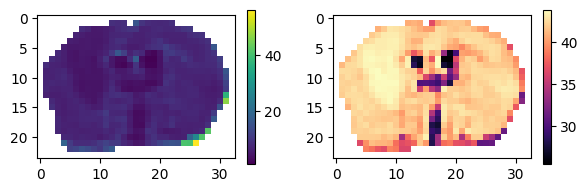

In [ ]:
plt.figure(figsize=(7, 2))
plt.suptitle('MT params')
plt.subplot(1,2,1)
# [15:45,0,15:50]
plt.imshow(mt_tissue_params_est['fc_T'].squeeze() * 100);               plt.colorbar()
plt.title('fss')
plt.subplot(1,2,2)
plt.imshow(mt_tissue_params_est['kc_T'].squeeze(), cmap='magma'); plt.colorbar()
plt.title('kss')
plt.show()

plt.figure(figsize=(7, 2))
plt.suptitle('rNOE params')
plt.subplot(1,2,1)
# [15:45,0,15:50]
plt.imshow(amide_tissue_params_est['fb_T'].squeeze() * 100);               plt.colorbar()
plt.title('fss')
plt.subplot(1,2,2)
plt.imshow(amide_tissue_params_est['kb_T'].squeeze(), cmap='magma'); plt.colorbar()
plt.title('kss')
plt.show()

/tmp/ipykernel_174783/2978797100.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_nrmse = plt.cm.get_cmap("YlOrRd").copy();  cmap_nrmse.set_bad('1.0')


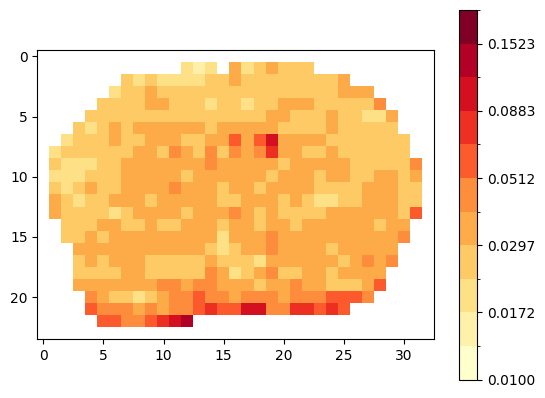

In [ ]:
import matplotlib.colors as mcolors

# Visualize the error maps in a slightly more informative way
err_mt = np.linalg.norm(mt_pred_signal_normed_np - data_feed_mt.measured_normed_T, axis=0) \
    / np.linalg.norm(data_feed_mt.measured_normed_T, axis=0)

mt_log_bins = np.logspace(np.log10(1.), np.log10(20), num=12)/100  # logarithmic
# log_bins = np.arange(0., 0.14, 0.01)  # Similar to R^2 coloring in paper
mt_norm = mcolors.BoundaryNorm(mt_log_bins, ncolors=plt.get_cmap('hot_r').N, clip=True)

mt_cmap_nrmse = plt.cm.get_cmap("YlOrRd").copy();  mt_cmap_nrmse.set_bad('1.0')
mt_img0 = plt.imshow(err_mt[:,0,:], norm=mt_norm, cmap=mt_cmap_nrmse) #'hot_r'); # plt.colorbar(img0)  # vmin=0, vmax=0.1,

mt_cbar = plt.colorbar(mt_img0)

plt.close()

# Visualize the error maps in a slightly more informative way
err_amide = np.linalg.norm(amide_pred_signal_normed_np - data_feed_amide.measured_normed_T, axis=0) \
    / np.linalg.norm(data_feed_amide.measured_normed_T, axis=0)

amide_log_bins = np.logspace(np.log10(1.), np.log10(20), num=12)/100  # logarithmic
# log_bins = np.arange(0., 0.14, 0.01)  # Similar to R^2 coloring in paper
amide_norm = mcolors.BoundaryNorm(amide_log_bins, ncolors=plt.get_cmap('hot_r').N, clip=True)

amide_cmap_nrmse = plt.cm.get_cmap("YlOrRd").copy();  amide_cmap_nrmse.set_bad('1.0')
amide_img0 = plt.imshow(err_amide[:,0,:], norm=amide_norm, cmap=amide_cmap_nrmse) #'hot_r'); # plt.colorbar(img0)  # vmin=0, vmax=0.1,

amide_cbar = plt.colorbar(amide_img0)

f_sigma stats: 0.064893395 0.31293637 7.16813
f_val stats: 1.0729288 7.2618966 56.45256
k_sigma stats: 2.9031427 4.2358737 24.094189
k_val stats: 25.534094 40.819675 43.8806


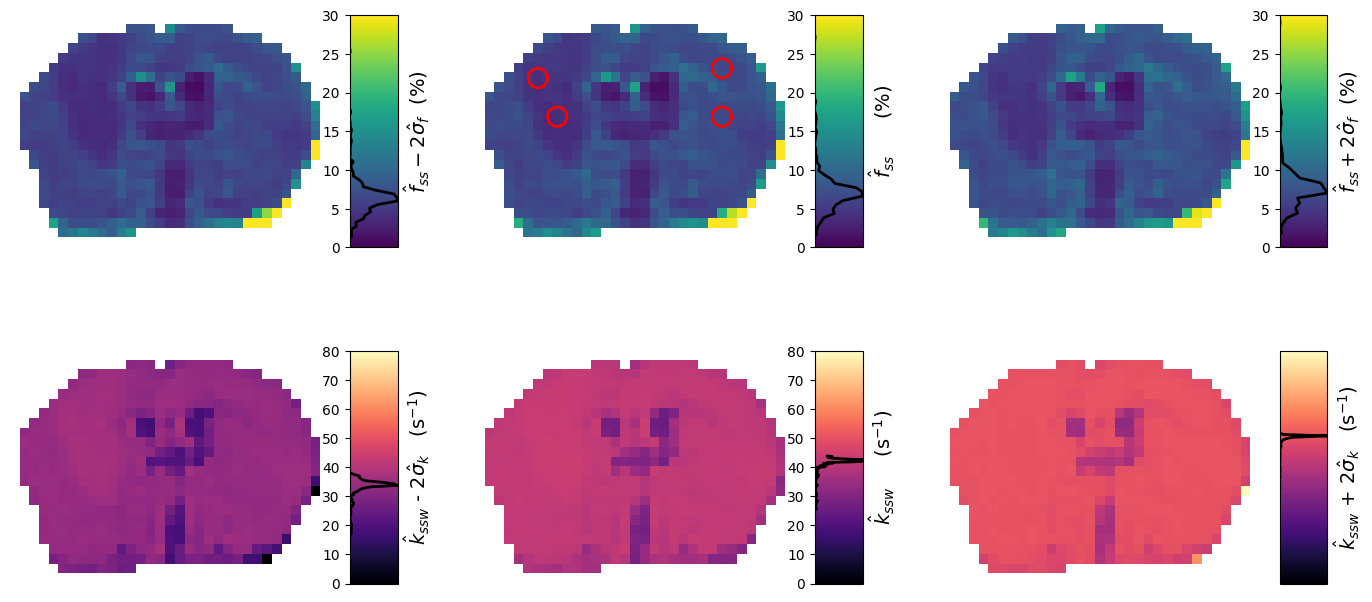

In [ ]:
import analyze_uncertainty as au
reload(au)

mt_tissue_param_est = mt_tissue_params_est

k_val = mt_tissue_param_est['kc_T'] # [:,sli,:]
f_val = 100*mt_tissue_param_est['fc_T'] #[:,sli,:]
u = mt_tissue_param_est['ucov'].reshape((*data_feed_mt.shape, 2, 2))
s = mt_tissue_param_est['scov'].reshape((*data_feed_mt.shape, 2, 2))
cov = mt_tissue_param_est['cov'].reshape((*data_feed_mt.shape, 2, 2))

dfk = np.array([1, 0])[None, None, None, :, None]
dfk = u @ jnp.sqrt(s) @ dfk
df_c_0 = dfk[..., 0, 0] * infer.infer_config.fc_scale_fact
dk_ca_0 = dfk[..., 1, 0] * infer.infer_config.kc_scale_fact
dfk = np.array([0, 1])[None, None, None, :, None]
dfk = u @ jnp.sqrt(s) @ dfk
df_c_1 = dfk[..., 0, 0] * infer.infer_config.fc_scale_fact
dk_ca_1 = dfk[..., 1, 0] * infer.infer_config.kc_scale_fact

f_total = np.sqrt(df_c_0**2 + df_c_1**2)
k_total = np.sqrt(dk_ca_0**2 + dk_ca_1**2)

f_sigma = 100*f_total
k_sigma = k_total


print("f_sigma stats:", np.nanmin(f_sigma), np.nanmean(f_sigma), np.nanmax(f_sigma))
print("f_val stats:", np.nanmin(f_val), np.nanmean(f_val), np.nanmax(f_val))
print("k_sigma stats:", np.nanmin(k_sigma), np.nanmean(k_sigma), np.nanmax(k_sigma))
print("k_val stats:", np.nanmin(k_val), np.nanmean(k_val), np.nanmax(k_val))

sli = 0
fig, axes = plt.subplots(2, 3, figsize=(17, 8))
explore_amide_uncertainty = False

map = f_val[:,sli,:] - 2*f_sigma[:,sli,:]
img = axes[0, 0].imshow(map, vmin=0, vmax=30 if not explore_amide_uncertainty else 1, cmap='viridis');
cbar = au.cbarhist(img, map,axes[0, 0], pad=0.2)
cbar.set_label(r'$\hat{f}_{ss} - 2\hat{\sigma}_f$  (%)'.replace('ss', 's' if explore_amide_uncertainty else 'ss'), fontsize=14)
cbar.ax.yaxis.set_ticks_position('left')
map = f_val[:,sli,:]
img = axes[0, 1].imshow(map, vmin=0, vmax=30 if not explore_amide_uncertainty else 1, cmap='viridis');
cbar = au.cbarhist(img, map,axes[0, 1], pad=0.2)
cbar.set_label(r'$\hat{f}_{ss}$      (%)'.replace('ss', 's' if explore_amide_uncertainty else 'ss'), fontsize=14)
cbar.ax.yaxis.set_ticks_position('left')
map = f_val[:,sli,:] + 2*f_sigma[:,sli,:]
img = axes[0, 2].imshow(map, vmin=0, vmax=30 if not explore_amide_uncertainty else 1, cmap='viridis');
cbar = au.cbarhist(img, map, axes[0, 2], pad=0.2)
cbar.set_label(r'$\hat{f}_{ss} + 2\hat{\sigma}_f$  (%)'.replace('ss', 's' if explore_amide_uncertainty else 'ss'), fontsize=14)
#cbar.set_label(r'f$_{ss}$ (%) :  $\mu+2\sigma$', fontsize=14)
cbar.ax.yaxis.set_ticks_position('left')
map = k_val[:,sli,:] - 2*k_sigma[:,sli,:]
img = axes[1, 0].imshow(map, vmin=0, vmax=80 if not explore_amide_uncertainty else 500, cmap='magma');
cbar = au.cbarhist(img, map,axes[1, 0], pad=0.2)
cbar.set_label(r'$\hat{k}_{ssw}$ - 2$\hat{\sigma}_k$   (s$^{-1}$)'.replace('ss', 's' if explore_amide_uncertainty else 'ss'), fontsize=14)
cbar.ax.yaxis.set_ticks_position('left')
map = k_val[:,sli,:]
img = axes[1, 1].imshow(map, vmin=0, vmax=80 if not explore_amide_uncertainty else 500, cmap='magma');
cbar = au.cbarhist(img, map,axes[1, 1], pad=0.2)
cbar.set_label(r'$\hat{k}_{ssw}$     (s$^{-1}$)'.replace('ss', 's' if explore_amide_uncertainty else 'ss'), fontsize=14)
cbar.ax.yaxis.set_ticks_position('left')
map = k_val[:,sli,:] + 2*k_sigma[:,sli,:]
img = axes[1, 2].imshow(map, vmin=0, vmax=80 if not explore_amide_uncertainty else 500, cmap='magma');
cbar = au.cbarhist(img, map, axes[1, 2], pad=0.2)
cbar.set_label(r'$\hat{k}_{ssw}$ + 2$\hat{\sigma}_k$   (s$^{-1}$)'.replace('ss', 's' if explore_amide_uncertainty else 'ss'), fontsize=14)
cbar.ax.yaxis.set_ticks_position('left')

for ax in axes.flatten():
    utils.remove_spines(ax)

import matplotlib.patches as patches

points = [[6, 6], [10, 8], [5, 25], [10, 25]]
for point in points:
    circle = patches.Circle((point[1], point[0]), 1, facecolor='none', edgecolor='red', linewidth=2)
    axes[0, 1].add_patch(circle)
    #axes[0, 1].set_ylim(map.shape[0], 0)

In [11]:
scales = np.array((100 * infer.infer_config.fb_scale_fact, infer.infer_config.kb_scale_fact)) if explore_amide_uncertainty \
    else np.array((100 * infer.infer_config.fc_scale_fact, infer.infer_config.kc_scale_fact))

_cov = u @ s @ np.transpose(u, [0,1,2,4,3])

# fig, axes = plt.subplots(1, 4, figsize=(20, 4)) #, figsize=(7, 3))
# jjj = 4
# for ax, (_x, _y) in zip(axes, [[25, 40], [30, 40], [25, 25], [30, 25]]):
#     # au.plot_empirical_nrmse_blob(ax, _x, _y, sli)
#     au.plot_ellipse(ax, _x, _y, sli, f_val, k_val, df_c_0, dk_ca_0, df_c_1, dk_ca_1, amide=explore_amide_uncertainty)
#     plt.plot()
#     f_best, k_best, nrmse, _df, _dk = au.plot_empirical_nrmse_blob(
#         ax, _x, _y, sli,
#         data_feed_mt, mt_tissue_param_est,
#         data_feed_amide=None, amide=explore_amide_uncertainty,
#         mt_sim_mode='expm_bmmat',
#     )

#     diff = np.array((f_val[_x, sli, _y] - f_best, k_val[_x, sli, _y] - k_best)) # / scales
#     mahalanobis = np.sqrt( (diff/scales).T @ np.linalg.inv(_cov[_x, sli, _y].T) @ (diff/scales) )
#     #mahalanobis = diff.T @ np.linalg.inv(scales[None, :] * _cov[_x, sli, _y] * scales[:, None]) @ diff
#     ax.set_title(mahalanobis)

(1, 1, 1, 1, 1, 1, 100, 100)


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


(1, 1, 1, 1, 1, 1, 100, 100)


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


(1, 1, 1, 1, 1, 1, 100, 100)


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


(1, 1, 1, 1, 1, 1, 100, 100)


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


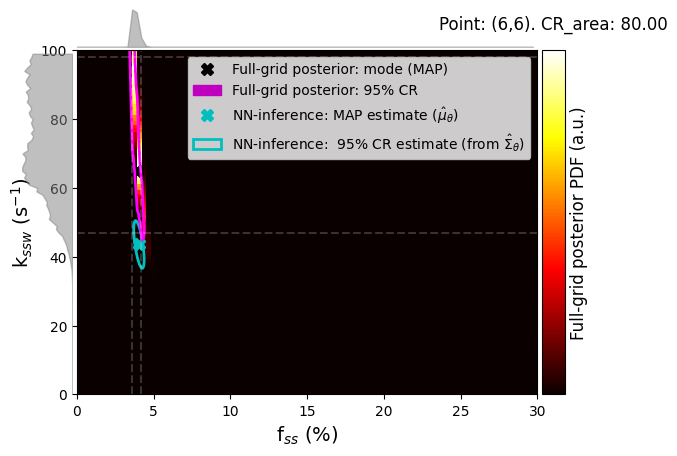

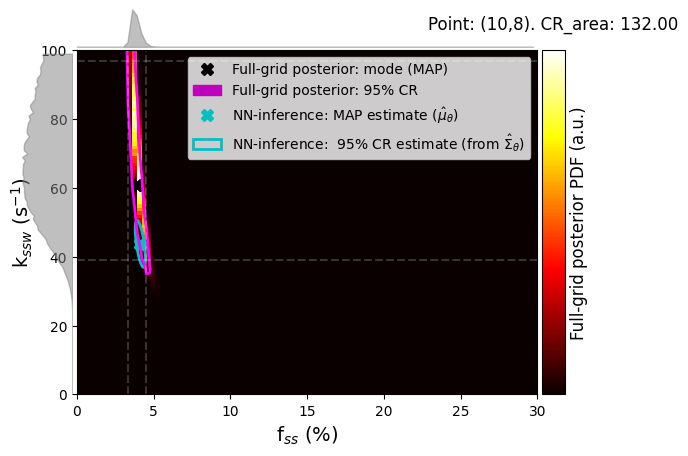

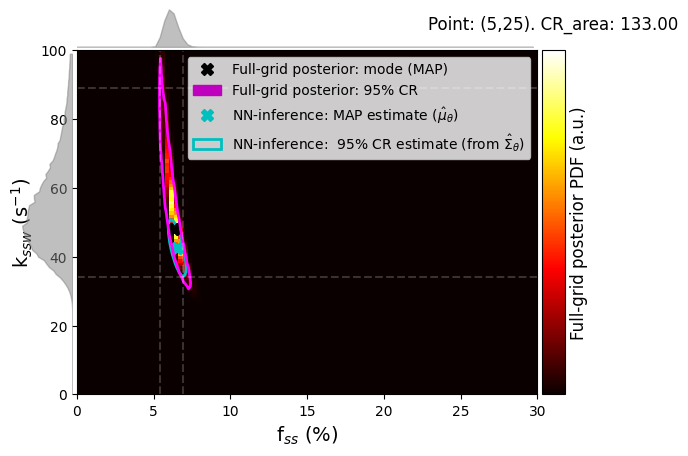

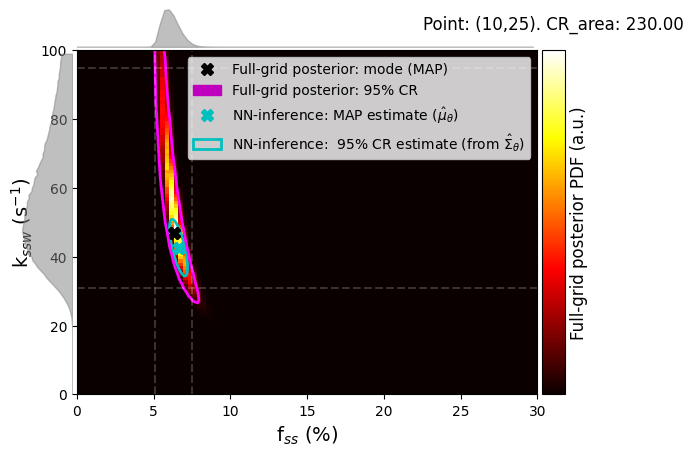

In [12]:
_z = 0
reload(au)

for jj, (_x, _y) in enumerate(points): # [[6, 6], [10, 8], [5, 25], [10, 25]]:
    f_best, k_best, nrmse, _df, _dk = au.plot_empirical_nrmse_blob(
        None, _x, _y, _z,
        data_feed_mt, mt_tissue_param_est,
        data_feed_amide=None, amide=False,
        mt_sim_mode='expm_bmmat', do_plot=False,
        mt_seq_txt_fname=inpt.mt_params_path, larg_seq_txt_fname=inpt.rnoe_params_path
    )
    maha1, maha2, posterior_cov, CR_area, CIk_x_CIf = au.viz_posteriors(
        f_val, k_val, _x, _y, _z,
        _cov, df_c_0, dk_ca_0, df_c_1, dk_ca_1,
        f_best, k_best, nrmse, _df, _dk,
        explore_amide_uncertainty=explore_amide_uncertainty, fontsize=14, # figsize=(6, 4),  # good w.o. marginals
        do_marginals=True, figsize=[7, 5], show_text=False, show_NN=True
        )
    plt.title(f'Point: ({_x},{_y}). CR_area: {CR_area:.2f}', 
              loc='center', 
              pad=15)  # Increase the pad value for more spacing
    

    # plt.savefig(f'./mouse_posterior_pics/ind{jj}_{_x}_{_z}_{_y}.png', dpi=200)
